In [21]:
#Imports
import xml.etree.ElementTree as ET
import pandas as pd
import re
import os
import pandas as pd
import nltk
import time
import datetime
import glob
import csv
import zipfile



from collections import Counter
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from collections import Counter
from tqdm import tqdm
from datetime import datetime
from collections import defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import matplotlib.dates as mdates



os.makedirs('FinalTDMOutputs', exist_ok=True)
os.makedirs('FullClean', exist_ok=True)
os.makedirs('MatrixResults', exist_ok=True)
os.makedirs('MatrixResults/Main', exist_ok=True)
os.makedirs('MatrixResults/TermSearchMatrix', exist_ok=True)


print('done with imports')

done with imports


From this we should have a folder called "FinalTDMOutputs" containing the csvs for each of the five terms. 

Now we move to step 2

=====================================================

# -----Analyis----- 
===========================================================

========================================================

# Duplicate Removal

"We then removed any duplicate title/context combinations."

#Remove duplicates for all the files
#Outputs files into a folder called FullClean/

In [22]:
def remove_duplicates_and_save(file_paths, output_folder="FullClean"):
    os.makedirs(output_folder, exist_ok=True)
    report = {}

    for path in file_paths:
        df = pd.read_csv(path)
        original_count = len(df)

        # Normalize titles for comparison
        if 'Title' in df.columns:
            df['title_key'] = df['Title'].astype(str).str.strip().str.lower() #lowercase 
        else:
            df['title_key'] = ''

        # Concatenate all context columns into one string
        context_cols = [col for col in df.columns if 'Context' in col]
        df['context_key'] = df[context_cols].astype(str).apply(lambda x: ' '.join(x.dropna()), axis=1)

        # Remove duplicates based on title and context content
        df_cleaned = df.drop_duplicates(subset=['title_key', 'context_key'], keep='first') #use dataframe 

        # Drop helper columns
        df_cleaned = df_cleaned.drop(columns=['title_key', 'context_key'])

        # Save cleaned file
        filename = os.path.basename(path)
        cleaned_path = os.path.join(output_folder, filename)
        df_cleaned.to_csv(cleaned_path, index=False)

        # Record and report
        cleaned_count = len(df_cleaned)
        removed_count = original_count - cleaned_count
        report[filename] = removed_count
        print(f" {removed_count} duplicates removed — saved to {cleaned_path}")

    return report

file_list = glob.glob("FinalTDMOutputs/*.csv")
report = remove_duplicates_and_save(file_list)

# Print summary if wanted. 
# print("\n Duplicate Removal Report:")
# for file, removed in report.items():
#     print(f"{file}: {removed} duplicates removed")

C:\Users\Bryce Greene\AppData\Local\Temp\ipykernel_3160\3807214079.py:6: DtypeWarning: Columns (53) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


 3384 duplicates removed — saved to FullClean\Cleaned_Full_Win25_conspiracy.csv
 2027 duplicates removed — saved to FullClean\Cleaned_Full_Win25_disinformation.csv
 1344 duplicates removed — saved to FullClean\Cleaned_Full_Win25_fake_news.csv
 3432 duplicates removed — saved to FullClean\Cleaned_Full_Win25_misinformation.csv


C:\Users\Bryce Greene\AppData\Local\Temp\ipykernel_3160\3807214079.py:6: DtypeWarning: Columns (54) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


 9328 duplicates removed — saved to FullClean\Cleaned_Full_Win25_propagada.csv


=======================================================================================

"We removed all multi-letter stopwords (e.g. “the” “and” “of”) using the Natural Language Toolkit package, and augmenting their stopwords with our own list developed during data exploration (See Appendix). We further cleaned the text using a set of stem mappings developed during exploration (i.e. turning ‘ukrainian’ to ‘ukraine’, ‘trumps’ to ‘trump’, or ‘coronavirus’ to ‘covid19’)(See Appendix). We also included a custom list of n-grams based on data exploration to better capture core concepts; (i.e., “fake news”, “white house”, “u k” or “u s s r”) (See Appendix). We then removed any remaining single-letter words that were not a part of an n-gram."


# Hardcoded ngrams and term mappings

These functions clean the text and apply ngrams in the process of analysis. They are used later in the script. 

In [23]:
# Hardcoded term mappings (can be expanded as needed)
TERM_MAPPINGS = {
    
    #Platforms
    'facebooks' : 'facebook',
    'twitters': 'twitter',
    'tweet': 'twitter',
    'tweeting': 'twitter',
    'tweeted': 'twitter',
    'Tiktoker': 'tiktok',
    'youtuber': 'youtube',
    'redditor': 'reddit',
    'militarys': 'military',
    'militaries': 'military',
    
    #Trump
    'trumps': 'trump',
    'presidents': 'president',
    'presidential': 'president',
    'republicans': 'republican',
    
     #Nations
    'koreas': 'korea',
    'korean': 'korea',
    
    'mexican': 'mexico',
    'mexicans': 'mexico',
  
    'russias': 'russia',
    'russian': 'russia',
    'kremlin': 'russia',
    'putins': 'putin',

    'chinese': 'china',
    'chinas': 'china',
   
    'ukraines': 'ukraine',
    'ukrainian': 'ukraine',
    'ukrainians': 'ukraine',
    

    'germanys': 'germany',
    'german': 'germany',
    
    'israels': 'israel',
    'israeli': 'israel',
    'israelis': 'israel',
    
    'iranian': 'iran',
    'irans': 'iran',
    'iranians': 'iran',
    
    'turkeys': 'turkey',
    'turkish': 'turkey',
    
    'french': 'france',
    'frances': 'france',
    
    'indian': 'india',
    'indias': 'india',
     
    'pakistani': 'pakistan',
    'pakistans': 'pakistan',
    
    'european': 'europe',
    'europes': 'europe',
    #Other countries added as needed
    
    #America
    'american': 'america',
    'americas': 'america',
    'americans': 'america',
    
    #COVID
    'vaccines': 'vaccine',
    'vaccination': 'vaccine',
    'vaccinations': 'vaccine',
    'vaccinated': 'vaccine',
    'vaccinate': 'vaccine',
    'coronavirus': 'covid19',
    'covid': 'covid19',
    
    #People
    'conways': 'conway',
    'clintons': 'clinton',
    'democrats': 'democrats',
    
    #Words
    'campaigns': 'campaign',
    'elections':'election',
    'spreading': 'spread',
    'spreads': 'spread',
    'platforms': 'platform',
    'officials': 'official',
    'governments': 'government',
    'users': 'user',
    'uses': 'use',
    'used': 'use',
    'journalists': 'journalist',
    'medias': 'media',
    'years': 'year',
    'wars': 'war',
    'groups': 'group',
    'terrorists': 'terrorist',
    'posts': 'post',
    'posting': 'post',
    'posted': 'post',
    'sites': 'site',
    'claimed': 'claim',
    'claims': 'claim',
    'companies': 'company',
    'companys': 'company',
    'accounts': 'account',
    'efforts': 'effort',
    'speeches': 'speech',
    'stories': 'story',
    'outlets': 'outlet',
    'including': 'include',
    'inclusion': 'include', 
    'worlds': 'world',
        
}


MANUAL_EXCLUDE = {'also', 'said', 'mr', 'us', 'would', 'one', 'people', 'like', 'many', 'could', '', '--', ' ', 'de', 'la'}
# N-GRAMS
BIGRAMS = {
    ('u', 'k'): 'uk',
    ('u', 'n'): 'un',
    ('u', 's'): 'us',
    ('e', 'u'): 'eu',
    ('jan', '6'): 'jan 6',
    ('fake', 'news'): 'fake news',
    ('white', 'house'): 'white house',
    ('social', 'media'): 'social media',
    ('new', 'media'): 'new media',
    ('islamic', 'state'): 'islamic state',
    ('press', 'secretary'): 'press secretary',
    ('donald', 'trump'): 'trump',
    ('president', 'trump'): 'trump',
    ('president', 'biden'): 'biden',
    
    ('alternative', 'facts'): 'alternative facts',
    ('alternative', 'fact'): 'alternative facts',
    ('conspiracy', 'theory'): 'conspiracy theory',
    ('conspiracy', 'theories'): 'conspiracy theory',
    ('kellyanne', 'conway'): 'conway',
    ('sean', 'spicer'): 'spicer',
    ('a', 'i'): 'artificial intelligence',
    ('artificial', 'intelligence'): 'artificial intelligence',
    ('state', 'sponsored'): 'state sponsored',
    ('soviet', 'union'): 'ussr',
    ('european', 'union'): 'europe',
    
    ('north', 'korea'): 'north korea',
    ('south', 'korea'): 'south korea',
    
    ('hillary', 'clinton'): 'clinton',
}
TRIGRAMS = {
    
    ('u', 's', 'a'): 'usa',
    ('f', 'b', 'i'): 'fbi',
    ('c', 'i', 'a'): 'cia',
    ('g', 'r', 'u'): 'gru',
    ('k', 'g', 'b'): 'kgb',
    ('u', 'f', 'o'): 'ufo',
    ('u', 'a', 'p'): 'uap',
    ('i', 'r', 'a'): 'ira',
    ('internet', 'research', 'agency'): 'ira',
    ('social', 'media', 'platform'): 'social media',
}
QUADGRAMS = {
    ('u', 's', 's', 'r'): 'ussr',
}

#taking these single letters out of stopwords library. We need these
fixed = stopwords.words('english')
fixed.remove('s')
fixed.remove('t')
fixed.remove('i')
fixed.remove('a')
stop_words = set(fixed)
stop_words.update(MANUAL_EXCLUDE)

def apply_stemming_and_cleaning(word):
    """
    Lowercases, applies term mappings, and skips stopwords.
    """
    word = word.lower()
    if word in TERM_MAPPINGS:
        word = TERM_MAPPINGS[word]
    if word in stop_words:
        return 0
    return word


 #applies existing ngrams to a row of words. 

def apply_ngrams(word_list):
    """
    Scans a list of words and replaces matching bigrams, trigrams, quadgrams.
    """
    i = 0
    result = []
    while i < len(word_list):
        
        # Check quadgrams first
        if i + 3 < len(word_list) and tuple(word_list[i:i+4]) in QUADGRAMS: #If there are more opportunities for QGs, and the next four letters form a quadgram
            result.append(QUADGRAMS[tuple(word_list[i:i+4])]) #add the quadgram  to the main list
            i += 4
        # Then trigrams
        elif i + 2 < len(word_list) and tuple(word_list[i:i+3]) in TRIGRAMS:
            result.append(TRIGRAMS[tuple(word_list[i:i+3])])
            i += 3
        # Then bigrams
        elif i + 1 < len(word_list) and tuple(word_list[i:i+2]) in BIGRAMS:
            #print("found", (BIGRAMS[tuple(word_list[i:i+2])]))
            # if (BIGRAMS[tuple(word_list[i:i+2])] == 'fake news'):
            #     print('Fake news FOUND')
            result.append(BIGRAMS[tuple(word_list[i:i+2])])
            i += 2
        else:
            if not (len(word_list[i]) == 1): #remove single letter words
                result.append(word_list[i])
                i += 1
            else:
                i += 1
    return result

print('Stemming and mapping functions created')

Stemming and mapping functions created


# Helper to deal with filenames

In [24]:
def get_output_filename(filepath, start, end, termName=None):
       # Extract the filename without extension
        file_name = os.path.basename(filepath)
        base_name = os.path.splitext(file_name)[0]

        # Remove 'Cleaned_Full' prefix if present
        if base_name.startswith("Cleaned_Full"):
            base_name = base_name.replace("Cleaned_Full", "").strip('_')
        
        if termName:
            base_name = f'{termName}_{base_name}_Matrix_{start}_{end}.csv'
        else:
            base_name = f'{base_name}_Matrix_{start}_{end}.csv'
        
        return base_name
#todo, create new ngrams automatically
print('get filename function created')

get filename function created


# Process Single CSV 
Function to process individual csv and save the result in a table of the top terms by year

In [25]:
def process_single_csv(filepath, top_n=20, start_year=None, end_year=None):
    WordCountsByYear = {}
    #=== Step 1: Load CSV into DataFrame ===
    df = pd.read_csv(filepath)
    # === Step 2: Identify context columns ===
    context_columns = [col for col in df.columns if "Context" in col]
    # === Step 3: Loop through rows and check year consistency ===
    with tqdm(total=len(df), desc="Processing rows") as pbar:
        for index, row in df.iterrows():
            pbar.update(1)
            numeric_date = row.get("NumericDate")
            # Skip rows without a valid date
            try:
                row_year = pd.to_datetime(numeric_date).year
            except (ValueError, TypeError):
                continue  # Skip invalid dates
            
            # Skip row with years out of bounds
            if not (row_year >= start_year) and (row_year <= end_year): 
                continue  # Skip rows not matching the target year
        
        # === Step 4: While in row loop, Loop through context cells to extract words ===
            row_words = []
            raw_row = []
            for col in context_columns:
                cell_value = str(row[col]) if pd.notnull(row[col]) else ""
                
                # Clean word 
                raw_row.append(cell_value)
                cleaned_word = apply_stemming_and_cleaning(cell_value)
                if not cleaned_word == 0:
                    row_words.append(cleaned_word)
        # == Step 5: While in row loop, apply NGram Search    
            filtered_words = apply_ngrams(row_words)
        # == STep 6: While in row loop, Extract Word Counts For Year/word combo
            for word in filtered_words:
                #if word == 'u':
                    #print(raw_row)
                if row_year not in WordCountsByYear: #if new year in set, add new year dictionary to master dictionary for csv
                    WordCountsByYear[row_year] = {}
                if not word in WordCountsByYear[row_year]: # if word is not null and word not in the year/word combo, add a new one
                    WordCountsByYear[row_year][word] = 1
                else:
                    WordCountsByYear[row_year][word] += 1 # or add to existing year/word combo


        # == 6a 
          
                if row_year not in GlobalMatrix: #if new year in set, add new year dictionary to master dictionary for csv
                    GlobalMatrix[row_year] = {}
                if not word in GlobalMatrix[row_year]: # if word is not null and word not in the year/word combo, add a new one
                    GlobalMatrix[row_year][word] = 1
                else:
                    GlobalMatrix[row_year][word] += 1 # or add to existing year/word combo
            
        
                if not word in GlobalMatrix[row_year]: # if word is not null and word not in the year/word combo, add a new one
                    GlobalMatrix[row_year][word] = 1
                else:
                    GlobalMatrix[row_year][word] += 1 # or add to existing year/word combo
    
    # == 6b
                if not word in TotalMatrix: #if dictionary hasn't been created yet
                    TotalMatrix[word] = 1 #create initial count 
                else:
                    TotalMatrix[word] += 1 #add to total count
            
                    
        
    # == Step 7: Reorganize to sort by highest ccount 
    rows = []  # Prepare list to collect top words per year
    for year, word_dict in WordCountsByYear.items():
        # Convert word-count pairs to a sorted list (by count descending)
        sorted_words = sorted(word_dict.items(), key=lambda x: x[1], reverse=True)[:top_n]
        
        # Build a row: Year + Word 1 + Count 1 + Word 2 + Count 2 + ...
        row = {'Year': year} #Every row will be a year
        for i, (word, count) in enumerate(sorted_words, start=1):
            row[f'Word {i}'] = word #Add word to Collumn name
            row[f'Count {i}'] = count #Add count to column name
        rows.append(row)

    # Convert to DataFrame
    result_df = pd.DataFrame(rows).sort_values(by='Year')
    # Save

    output_path = get_output_filename(filepath, start_year, end_year)
    result_df.to_csv(f'MatrixResults/Main/{output_path}', index=False)

    print(f"DataFrame saved to {output_path}")
    
        
    
    
    # result_df.to_csv('top_20_words_by_year.csv', index=False)
print('process csv function created')

process csv function created


# Process all CSVs 

this function creates a matrix for every term, while creating a global matrix. They will be stored in the folder MatrixResults 

In [26]:
def process_all_csvs(input_folder='FullClean', top_n=20, start_year=None, end_year=None): #Create Individual Matrices For All 
    """
    Loops through all CSVs in the input folder and processes them to create a matrix for each term
    """
    TotalWordCounts = {}
    GlobalWordCountsByYear = {}
    
    for file in os.listdir(input_folder):
        if file.endswith('.csv'):
            filepath = os.path.join(input_folder, file)
            process_single_csv(filepath, top_n=top_n, start_year=start_year, end_year=end_year)
    
    #Do same logic as individual csvs
    rows = []  # Prepare list to collect top words per year

    #Everytime a CSV is processed, it adds word to a global matrix file
    for year, word_dict in GlobalMatrix.items(): #Loop through all word/count pairs found overall 
        # Convert word-count pairs to a sorted list (by count descending)
        sorted_words = sorted(word_dict.items(), key=lambda x: x[1], reverse=True)[:top_n]
        
        # Build a row for output csv: Year + Word 1 + Count 1 + Word 2 + Count 2 + ...
        row = {'Year': year} #Every row will be a year
        for i, (word, count) in enumerate(sorted_words, start=1):
            row[f'Word {i}'] = word #Add word to Collumn name
            row[f'Count {i}'] = count #Add count to column name
        rows.append(row)

    # Convert to DataFrame
    result_df = pd.DataFrame(rows).sort_values(by='Year')
    # Save
    
    word_counts_series = pd.Series(TotalMatrix).sort_values(ascending=False)
    print(word_counts_series.head(30))
          
          
    output_path = 'GlobalMatrix.csv'
    result_df.to_csv(f'MatrixResults/Main/{output_path}', index=False)

print('process all csvs function created')


process all csvs function created


# Word Search All Terms

This function runs specific word searches on the dataset

Results will be saved

In [32]:
def word_search_all_csvs(input_folder, search_terms, top_n=20, start_year=None, end_year=None, termNames='NO_NAME'):
    
    print('Searching for terms: ' + str(search_terms))
    TotalWordCounts = {}
    GlobalWordCountsByYear = {}
    
    search_terms = [term.lower() for term in search_terms]
    
    for file in os.listdir(input_folder):
        WordCountsByYear = {}
        if file.endswith('.csv'):
            filepath = os.path.join(input_folder, file)
    
            
            #=== Step 1: Load CSV into DataFrame ===
            df = pd.read_csv(filepath)
            # === Step 2: Identify context columns ===
            context_columns = [col for col in df.columns if "Context" in col]
            # === Step 3: Loop through rows and check year consistency ===
            #with tqdm(total=len(df), desc="Processing rows") as pbar:
            
            with tqdm(total=len(df), desc=f'Searching {filepath}') as pbar:
                for index, row in df.iterrows():
                    pbar.update(1)
                    numeric_date = row.get("NumericDate")
                    # Skip rows without a valid date
                    try:
                        row_year = pd.to_datetime(numeric_date).year
                    except (ValueError, TypeError):
                        continue  # Skip invalid dates
                    
                    # Skip row with years out of bounds
                    if not row_year in range(start_year, end_year + 1): #(row_year >= start_year) and (row_year <= end_year): 
                        #print(f'row_ {row_year}')
                        continue  # Skip rows not matching the target year
                    #else:
                        #print(f'row_ {row_year} is later thann {start_year} and arlier than {end_year}')
                # === Step 4: While in row loop, Loop through context cells ===
                    row_words = []
                    raw_row = []
                    for col in context_columns:
                        cell_value = str(row[col]) if pd.notnull(row[col]) else ""
                        
                        # Clean word 
                        raw_row.append(cell_value)
                        cleaned_word = apply_stemming_and_cleaning(cell_value)
                        if not cleaned_word == 0:
                            row_words.append(cleaned_word)
                # == Step 5: While in row loop, apply NGram Search    
                    filtered_words = apply_ngrams(row_words)
                # == STep 6: While in row loop, Extract Word Counts For Year/word combo
                    for word in filtered_words:
                        if word in search_terms: #If word is one of our search terms
                            
                            if not word in TotalWordCounts: #if dictionary hasn't been created yet
                                TotalWordCounts[word] = 1 #create initial count 
                            else:
                                TotalWordCounts[word] += 1 #add to total count
                                
                            
                            if row_year not in WordCountsByYear: #if new year in set, add new year dictionary to master dictionary for csv
                                WordCountsByYear[row_year] = {}
                            if not word in WordCountsByYear[row_year]: # if word is not null and word not in the year/word combo, add a new one
                                WordCountsByYear[row_year][word] = 1
                            else:
                                WordCountsByYear[row_year][word] += 1 # or add to existing year/word combo
                    
                    
                    for word in filtered_words:
                        if word in search_terms: #If word is one of our search terms
                            if row_year not in GlobalWordCountsByYear: #if new year in set, add new year dictionary to master dictionary for csv
                                GlobalWordCountsByYear[row_year] = {}
                            if not word in GlobalWordCountsByYear[row_year]: # if word is not null and word not in the year/word combo, add a new one
                                GlobalWordCountsByYear[row_year][word] = 1
                            else:
                                GlobalWordCountsByYear[row_year][word] += 1 # or add to existing year/word combo
                            
                    
            # == Step 7: Reorganize to sort by highest ccount 
            rows = []  # Prepare list to collect top words per year
            
            for year, word_dict in WordCountsByYear.items():
                # Convert word-count pairs to a sorted list (by count descending)
                sorted_words = sorted(word_dict.items(), key=lambda x: x[1], reverse=True)[:top_n]
                
                # Build a row: Year + Word 1 + Count 1 + Word 2 + Count 2 + ...
                row = {'Year': year} #Every row will be a year
                for i, (word, count) in enumerate(sorted_words, start=1):
                    row[f'Word {i}'] = word #Add word to Collumn name
                    row[f'Count {i}'] = count #Add count to column name
                rows.append(row)

            # Convert to DataFrame
            result_df = pd.DataFrame(rows).sort_values(by='Year')
            # Save
            os.makedirs(f'MatrixResults/TermSearchMatrix/{termNames}', exist_ok=True)
            output_path = get_output_filename(filepath, start_year, end_year, termName=termNames)
            result_df.to_csv(f'MatrixResults/TermSearchMatrix/{termNames}/{output_path}', index=False)

            print(f"DataFrame saved to {output_path}")
            
        
            
    
    word_counts_series = pd.Series(TotalWordCounts).sort_values(ascending=False)
    print(word_counts_series.head(30))    
    
    rows = [] #cleanse
    #Get Totals
    for year, word_dict in GlobalWordCountsByYear.items():
        # Convert word-count pairs to a sorted list (by count descending)
        sorted_words = sorted(word_dict.items(), key=lambda x: x[1], reverse=True)[:top_n]
        
        # Build a row: Year + Word 1 + Count 1 + Word 2 + Count 2 + ...
        row = {'Year': year} #Every row will be a year
        for i, (word, count) in enumerate(sorted_words, start=1):
            row[f'Word {i}'] = word #Add word to Collumn name
            row[f'Count {i}'] = count #Add count to column name
        rows.append(row)

    # Convert to DataFrame
    result_df = pd.DataFrame(rows).sort_values(by='Year')
    # Save
    

    output_path = f'MatrixResults/TermSearchMatrix/{termNames}/{termNames}_GlobalMatrixTerms_{start_year}_{end_year}.csv'
    result_df.to_csv(output_path, index=False)
    
    
    # result_df.to_csv('top_20_words_by_year.csv', index=False)

print('word search function created')

word search function created


# Tally Counts Function

This function is able to tally the counts in preparation for graphing. 

In [28]:
# === Date Parsing Function ===
def parse_date(date_str):
    try: 
        return pd.to_datetime(date_str)
    except Exception as e:
        print(e)
        return None

# === Process Each File ===


def tallyCounts(data_folder, title, keywords=None):
    counts = defaultdict(int)

    # Normalize keywords and compile regex if provided
    if keywords:
        keywords = [kw.lower() for kw in keywords]
       
    for filename in os.listdir(data_folder):
        if not filename.endswith('.csv'):
            continue

        term = filename.replace('Cleaned_Full_Win25_', '').replace('.csv', '').strip()
        filepath = os.path.join(data_folder, filename)
        print(f"\nProcessing file: {filename}")

        try:
            df = pd.read_csv(filepath, dtype=str)
            df.columns = [col.strip().lower() for col in df.columns]

            with tqdm(total=len(df), desc=f"Processing {filename}") as pbar:
                text_columns = [col for col in df.columns if 'context' in col or 'keyword' in col]
                for idx, row in df.iterrows():
                    pbar.update(1)

                    # Date parsing
                    raw_date = row.get('numericdate', '')
                    parsed = parse_date(str(raw_date))
                    if not parsed:
                        continue
                    month_key = parsed.strftime('%Y-%m')

                    # Keyword counting logic
                    if keywords: #if we're using keywords in the search
                         for col in text_columns: #for every context column
                            val = row.get(col) # get the value for that column in this row
                            for keyword in keywords: #look through each keyword
                                if keyword == val: # if the value and keyword match
                                    counts[(keyword, month_key)] += 1 #set the counts dictionary
                    else: #if this isn't a key word search, we're just doing terms 
                        counts[(term, month_key)] += 1 #if this isn't a key word search, we're just doing terms 

        except Exception as e:
            print(f"Failed to read {filename}: {e}")

    # Build full index of (term, date) to ensure 0-filled months
    terms = set(term for term, _ in counts.keys())
    start_month = datetime(1980, 1, 1)
    end_month = datetime(2025, 7, 1)
    all_months = pd.date_range(start=start_month, end=end_month, freq='MS')
    all_months_str = [d.strftime('%Y-%m') for d in all_months]
    full_index = [(term, month) for term in terms for month in all_months_str]

    # Fill with zeros where missing
    full_data = [
        {'term': term, 'date': month, 'count': counts.get((term, month), 0)}
        for (term, month) in full_index
    ]

    df_out = pd.DataFrame(full_data)
    
    output_csv_path=f'FinalCombinedOutput/{title}.csv'
    
    os.makedirs(os.path.dirname(output_csv_path), exist_ok=True)
    df_out.to_csv(output_csv_path, index=False)
    print(f"✅ Saved CSV with zero-filled counts to: {output_csv_path}")
    
 

# Generates Area Graph

In [29]:
def plot_stacked_area(csv_path, title, start_year, end_year):
    # Load CSV and parse dates
    df = pd.read_csv(csv_path)
    
    # Group by 'term' and sum all counts
    term_totals = df.groupby('term')['count'].sum()

    # Sort descending and get top 5
    top_terms = term_totals.sort_values(ascending=False).head(5)

    # If you want to filter the original DataFrame to just these terms:
    df = df[df['term'].isin(top_terms.index)]
    
    
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m')

    # Create datetime range boundaries
    start = pd.to_datetime(f'{start_year}-01-01')
    end = pd.to_datetime(f'{end_year}-12')

    # Pivot to wide format and filter date range
    wide_df = df.pivot_table(index='date', columns='term', values='count', fill_value=0)
    wide_df.sort_index(inplace=True)
    wide_df = wide_df[(wide_df.index >= start) & (wide_df.index <= end)]

    # Use a colorblind-friendly palette (CUD: Color Universal Design)
    color_palette = [
        "#E69F00",  # orange
        "#56B4E9",  # blue
        "#009E73",  # green
        "#F0E442",  # yellow
        "#0072B2",  # navy
        "#D55E00",  # vermilion
        "#CC79A7",  # pink
        "#999999",  # grey
    ]
    # Repeat colors if there are more terms than colors in palette
    colors = color_palette * (len(wide_df.columns) // len(color_palette) + 1)
    output_path=f'{title} ({start_year}–{end_year}).png'
    # Plot
    plt.figure(figsize=(18, 9))
    plt.stackplot(wide_df.index, wide_df.T.values, labels=wide_df.columns, colors=colors[:len(wide_df.columns)])
    
    ax = plt.gca()
    
    
    num_months = (wide_df.index.max().to_period('M') - wide_df.index.min().to_period('M')).n

    # Choose interval based on total duration
    
    dateFormat = '%b %Y'
    if num_months <= 24:
        interval = 1   # monthly ticks
    elif num_months <= 60:
        interval = 3   # quarterly
    elif num_months <= 120:
        interval = 6   # semi-annual
    else:
        interval = 12  # yearly
        dateFormat = '%Y'

    # Set major ticks every 3 months
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=interval))
    
    # Format: show abbreviated month and full year
    ax.xaxis.set_major_formatter(mdates.DateFormatter(dateFormat))
    
    # Rotate labels vertically
    plt.xticks(rotation=90)
    
    # Optional: grid lines and layout
    ax.grid(True, linestyle='--', alpha=0.5)

    # Labels and formatting
    plt.title(f'{title} ({start_year}–{end_year})', fontsize=20)
    plt.xlabel('Date')
    plt.xlim(start, end)
    plt.ylabel('Count')
    plt.legend(loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()

    # Save high-resolution PNG
    os.makedirs('Figures', exist_ok=True)
    plt.savefig(f'Figures/{output_path}', dpi=300, bbox_inches='tight')
    print(f"Saved plot as PNG: {output_path}")
    plt.show()

print('Graphing function created')

Graphing function created


# MAIN DRIVERS

In [30]:
#Creates empty variables to be added


# Define folder paths
INPUT_FOLDER = 'FullClean'

TOP_N_WORDS = 30
START_YEAR = 2016
END_YEAR = 2024
    

searchObjectList = [
    {
        'title': 'keyword_monthly_counts',
        'graph_title': 'Term Occurence In Malinformation Dataset',
        'list': None
    },
    {
        'in_path' : 'FinalCombinedOutput/platforms.csv',
        'title': 'platforms',
        'graph_title': 'Platform Mentions In Malinformation Dataset',
        'list': ['facebook', 'twitter', 'instagram', 'tiktok', 'youtube', 'snapchat', 'whatsapp', 'telegram', 'reddit']
    },
    {
        'in_path' : 'FinalCombinedOutput/leaders.csv',
        'title': 'leaders',
        'graph_title': 'World Leader Mentions In Malinformation Dataset',
        'list': ['biden', 'trump', 'clinton', 'xi', 'putin', 'netanyahu']
    },
    {
        'in_path' : 'FinalCombinedOutput/countries.csv',
        'title': 'countries',
        'graph_title': 'Non-US Country Mentions In Malinformation Dataset',
        'list':  ['Afghanistan', 'ussr', 'yugoslavia', 'Aland Islands', 'Albania', 'Algeria', 'American Samoa', 'Andorra', 'Angola', 'Anguilla', 'Antarctica', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bermuda', 'Bhutan', 'Bolivia', 'Bonaire, Sint Eustatius and Saba', 'Bosnia and Herzegovina', 'Botswana', 'Bouvet Island', 'Brazil', 'British Indian Ocean Territory', 'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde', 'Cayman Islands', 'Central African Republic', 'Chad', 'Chile', 'China', 'Christmas Island', 'Cocos (Keeling) Islands', 'Colombia', 'Comoros', 'Congo', 'Congo, The Democratic Republic of the', 'Cook Islands', 'Costa Rica', "Côte d'Ivoire", 'Croatia', 'Cuba', 'Curaçao', 'Cyprus', 'Czech Republic', 'Denmark', 'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia', 'Ethiopia', 'Falkland Islands (Malvinas)', 'Faroe Islands', 'Fiji', 'Finland', 'France', 'French Guiana', 'French Polynesia', 'French Southern Territories', 'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana', 'Gibraltar', 'Greece', 'Greenland', 'Grenada', 'Guadeloupe', 'Guam', 'Guatemala', 'Guernsey', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti', 'Heard Island and McDonald Islands', 'Holy See (Vatican City State)', 'Honduras', 'Hong Kong', 'Hungary', 'Iceland', 'India', 'Indonesia', 'Iran', 'Iraq', 'Ireland', 'Isle of Man', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Jersey', 'Jordan', 'Kazakhstan', 'Kenya', 'Kiribati', "North korea", 'South Korea', 'Kuwait', 'Kyrgyzstan', "Lao People's Democratic Republic", 'Latvia', 'Lebanon', 'Lesotho', 'Liberia', 'Libya', 'Liechtenstein', 'Lithuania', 'Luxembourg', 'Macao', 'Macedonia, Republic of', 'Madagascar', 'Malawi', 'Malaysia', 'Maldives', 'Mali', 'Malta', 'Marshall Islands', 'Martinique', 'Mauritania', 'Mauritius', 'Mayotte', 'Mexico', 'Micronesia, Federated States of', 'Moldova', 'Monaco', 'Mongolia', 'Montenegro', 'Montserrat', 'Morocco', 'Mozambique', 'Myanmar', 'Namibia', 'Nauru', 'Nepal', 'Netherlands', 'New Caledonia', 'New Zealand', 'Nicaragua', 'Niger', 'Nigeria', 'Niue', 'Norfolk Island', 'Northern Mariana Islands', 'Norway', 'Oman', 'Pakistan', 'Palau', 'Palestinian Territory, Occupied', 'Panama', 'Papua New Guinea', 'Paraguay', 'Peru', 'Philippines', 'Pitcairn', 'Poland', 'Portugal', 'Puerto Rico', 'Qatar', 'Réunion', 'Romania', 'russia', 'Rwanda', 'Saint Barthélemy', 'Saint Helena, Ascension and Tristan da Cunha', 'Saint Kitts and Nevis', 'Saint Lucia', 'Saint Martin (French part)', 'Saint Pierre and Miquelon', 'Saint Vincent and the Grenadines', 'Samoa', 'San Marino', 'Sao Tome and Principe', 'Saudi Arabia', 'Senegal', 'Serbia', 'Seychelles', 'Sierra Leone', 'Singapore', 'Sint Maarten (Dutch part)', 'Slovakia', 'Slovenia', 'Solomon Islands', 'Somalia', 'South Africa', 'South Georgia and the South Sandwich Islands', 'Spain', 'Sri Lanka', 'Sudan', 'Suriname', 'South Sudan', 'Svalbard and Jan Mayen', 'Swaziland', 'Sweden', 'Switzerland', 'Syrian Arab Republic', 'Taiwan', 'Tajikistan', 'Tanzania', 'Thailand', 'Timor-Leste', 'Togo', 'Tokelau', 'Tonga', 'Trinidad and Tobago', 'Tunisia', 'Turkey', 'Turkmenistan', 'Turks and Caicos Islands', 'Tuvalu', 'Uganda', 'Ukraine', 'United Arab Emirates', 'uk', 'United States Minor Outlying Islands', 'Uruguay', 'Uzbekistan', 'Vanuatu', 'Venezuela', 'Vietnam', 'Virgin Islands', 'Wallis and Futuna', 'Yemen', 'Zambia', 'Zimbabwe']
    },
]

# Analyze Data

In [33]:
for object in searchObjectList:
    GlobalMatrix = {}
    TotalMatrix = {}
    tallyCounts(INPUT_FOLDER, object['title'], object['list']) 
    if (object['list']):
       word_search_all_csvs( INPUT_FOLDER, object['list'], TOP_N_WORDS, START_YEAR, END_YEAR, object['title'])
    else:
        process_all_csvs(top_n=TOP_N_WORDS, start_year=START_YEAR, end_year=END_YEAR)


Processing file: Cleaned_Full_Win25_conspiracy.csv


Processing Cleaned_Full_Win25_conspiracy.csv: 100%|██████████| 57782/57782 [00:48<00:00, 1180.89it/s]



Processing file: Cleaned_Full_Win25_disinformation.csv


Processing Cleaned_Full_Win25_disinformation.csv: 100%|██████████| 41371/41371 [00:30<00:00, 1336.33it/s]



Processing file: Cleaned_Full_Win25_fake_news.csv


Processing Cleaned_Full_Win25_fake_news.csv: 100%|██████████| 28745/28745 [00:21<00:00, 1341.49it/s]



Processing file: Cleaned_Full_Win25_misinformation.csv


Processing Cleaned_Full_Win25_misinformation.csv: 100%|██████████| 58378/58378 [00:42<00:00, 1375.11it/s]



Processing file: Cleaned_Full_Win25_propagada.csv


Processing Cleaned_Full_Win25_propagada.csv: 100%|██████████| 113310/113310 [01:25<00:00, 1320.10it/s]


✅ Saved CSV with zero-filled counts to: FinalCombinedOutput/keyword_monthly_counts.csv


C:\Users\Bryce Greene\AppData\Local\Temp\ipykernel_3160\3009274302.py:4: DtypeWarning: Columns (53) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath)
Processing rows: 100%|██████████| 57782/57782 [01:11<00:00, 807.38it/s]


DataFrame saved to Win25_conspiracy_Matrix_2016_2024.csv


Processing rows: 100%|██████████| 41371/41371 [00:50<00:00, 818.39it/s]


DataFrame saved to Win25_disinformation_Matrix_2016_2024.csv


Processing rows: 100%|██████████| 28745/28745 [00:45<00:00, 636.74it/s]


DataFrame saved to Win25_fake_news_Matrix_2016_2024.csv


Processing rows: 100%|██████████| 58378/58378 [01:39<00:00, 584.94it/s]


DataFrame saved to Win25_misinformation_Matrix_2016_2024.csv


C:\Users\Bryce Greene\AppData\Local\Temp\ipykernel_3160\3009274302.py:4: DtypeWarning: Columns (54) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath)
Processing rows: 100%|██████████| 113310/113310 [02:43<00:00, 693.32it/s]


DataFrame saved to Win25_propagada_Matrix_2016_2024.csv
trump           44922
russia          36022
election        29139
spread          26387
president       23469
facebook        21546
campaign        20333
news            19538
america         18823
company         18065
media           17265
twitter         17179
new             16652
year            16461
social media    16346
government      15923
political       15110
use             14591
china           14239
official        13785
post            13302
group           12666
vaccine         12470
us              12028
online          11974
include         11934
information     11469
public          11347
even            11299
ukraine         11153
dtype: int64

Processing file: Cleaned_Full_Win25_conspiracy.csv


Processing Cleaned_Full_Win25_conspiracy.csv: 100%|██████████| 57782/57782 [01:14<00:00, 774.68it/s]



Processing file: Cleaned_Full_Win25_disinformation.csv


Processing Cleaned_Full_Win25_disinformation.csv: 100%|██████████| 41371/41371 [00:55<00:00, 744.58it/s]



Processing file: Cleaned_Full_Win25_fake_news.csv


Processing Cleaned_Full_Win25_fake_news.csv: 100%|██████████| 28745/28745 [00:38<00:00, 749.90it/s]



Processing file: Cleaned_Full_Win25_misinformation.csv


Processing Cleaned_Full_Win25_misinformation.csv: 100%|██████████| 58378/58378 [01:15<00:00, 777.83it/s]



Processing file: Cleaned_Full_Win25_propagada.csv


Processing Cleaned_Full_Win25_propagada.csv: 100%|██████████| 113310/113310 [02:26<00:00, 772.21it/s]


✅ Saved CSV with zero-filled counts to: FinalCombinedOutput/platforms.csv
Searching for terms: ['facebook', 'twitter', 'instagram', 'tiktok', 'youtube', 'snapchat', 'whatsapp', 'telegram', 'reddit']


C:\Users\Bryce Greene\AppData\Local\Temp\ipykernel_3160\1356934491.py:16: DtypeWarning: Columns (53) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath)
Searching FullClean\Cleaned_Full_Win25_conspiracy.csv: 100%|██████████| 57782/57782 [01:34<00:00, 611.10it/s]


DataFrame saved to platforms_Win25_conspiracy_Matrix_2016_2024.csv


Searching FullClean\Cleaned_Full_Win25_disinformation.csv: 100%|██████████| 41371/41371 [01:02<00:00, 657.64it/s]


DataFrame saved to platforms_Win25_disinformation_Matrix_2016_2024.csv


Searching FullClean\Cleaned_Full_Win25_fake_news.csv: 100%|██████████| 28745/28745 [00:48<00:00, 587.02it/s]


DataFrame saved to platforms_Win25_fake_news_Matrix_2016_2024.csv


Searching FullClean\Cleaned_Full_Win25_misinformation.csv: 100%|██████████| 58378/58378 [01:25<00:00, 685.62it/s]


DataFrame saved to platforms_Win25_misinformation_Matrix_2016_2024.csv


C:\Users\Bryce Greene\AppData\Local\Temp\ipykernel_3160\1356934491.py:16: DtypeWarning: Columns (54) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath)
Searching FullClean\Cleaned_Full_Win25_propagada.csv: 100%|██████████| 113310/113310 [02:13<00:00, 849.92it/s]


DataFrame saved to platforms_Win25_propagada_Matrix_2016_2024.csv
facebook     21372
twitter      17134
youtube       4139
tiktok        2252
instagram     1563
whatsapp      1165
telegram       819
reddit         351
snapchat        91
dtype: int64

Processing file: Cleaned_Full_Win25_conspiracy.csv


Processing Cleaned_Full_Win25_conspiracy.csv: 100%|██████████| 57782/57782 [01:07<00:00, 854.85it/s]



Processing file: Cleaned_Full_Win25_disinformation.csv


Processing Cleaned_Full_Win25_disinformation.csv: 100%|██████████| 41371/41371 [00:48<00:00, 854.57it/s]



Processing file: Cleaned_Full_Win25_fake_news.csv


Processing Cleaned_Full_Win25_fake_news.csv: 100%|██████████| 28745/28745 [00:35<00:00, 799.58it/s]



Processing file: Cleaned_Full_Win25_misinformation.csv


Processing Cleaned_Full_Win25_misinformation.csv: 100%|██████████| 58378/58378 [01:11<00:00, 820.91it/s]



Processing file: Cleaned_Full_Win25_propagada.csv


Processing Cleaned_Full_Win25_propagada.csv: 100%|██████████| 113310/113310 [02:16<00:00, 832.14it/s]


✅ Saved CSV with zero-filled counts to: FinalCombinedOutput/leaders.csv
Searching for terms: ['biden', 'trump', 'clinton', 'xi', 'putin', 'netanyahu']


C:\Users\Bryce Greene\AppData\Local\Temp\ipykernel_3160\1356934491.py:16: DtypeWarning: Columns (53) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath)
Searching FullClean\Cleaned_Full_Win25_conspiracy.csv: 100%|██████████| 57782/57782 [01:20<00:00, 720.13it/s]


DataFrame saved to leaders_Win25_conspiracy_Matrix_2016_2024.csv


Searching FullClean\Cleaned_Full_Win25_disinformation.csv: 100%|██████████| 41371/41371 [00:59<00:00, 692.30it/s]


DataFrame saved to leaders_Win25_disinformation_Matrix_2016_2024.csv


Searching FullClean\Cleaned_Full_Win25_fake_news.csv: 100%|██████████| 28745/28745 [00:52<00:00, 551.53it/s]


DataFrame saved to leaders_Win25_fake_news_Matrix_2016_2024.csv


Searching FullClean\Cleaned_Full_Win25_misinformation.csv: 100%|██████████| 58378/58378 [01:27<00:00, 668.04it/s]


DataFrame saved to leaders_Win25_misinformation_Matrix_2016_2024.csv


C:\Users\Bryce Greene\AppData\Local\Temp\ipykernel_3160\1356934491.py:16: DtypeWarning: Columns (54) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath)
Searching FullClean\Cleaned_Full_Win25_propagada.csv: 100%|██████████| 113310/113310 [02:26<00:00, 776.02it/s]


DataFrame saved to leaders_Win25_propagada_Matrix_2016_2024.csv
trump        43264
biden         6011
putin         4599
clinton       3381
xi             936
netanyahu      178
dtype: int64

Processing file: Cleaned_Full_Win25_conspiracy.csv


Processing Cleaned_Full_Win25_conspiracy.csv: 100%|██████████| 57782/57782 [01:44<00:00, 551.54it/s]



Processing file: Cleaned_Full_Win25_disinformation.csv


Processing Cleaned_Full_Win25_disinformation.csv: 100%|██████████| 41371/41371 [01:18<00:00, 529.23it/s]



Processing file: Cleaned_Full_Win25_fake_news.csv


Processing Cleaned_Full_Win25_fake_news.csv: 100%|██████████| 28745/28745 [00:55<00:00, 518.70it/s]



Processing file: Cleaned_Full_Win25_misinformation.csv


Processing Cleaned_Full_Win25_misinformation.csv: 100%|██████████| 58378/58378 [01:44<00:00, 556.39it/s]



Processing file: Cleaned_Full_Win25_propagada.csv


Processing Cleaned_Full_Win25_propagada.csv: 100%|██████████| 113310/113310 [03:13<00:00, 585.91it/s]


✅ Saved CSV with zero-filled counts to: FinalCombinedOutput/countries.csv
Searching for terms: ['Afghanistan', 'ussr', 'yugoslavia', 'Aland Islands', 'Albania', 'Algeria', 'American Samoa', 'Andorra', 'Angola', 'Anguilla', 'Antarctica', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bermuda', 'Bhutan', 'Bolivia', 'Bonaire, Sint Eustatius and Saba', 'Bosnia and Herzegovina', 'Botswana', 'Bouvet Island', 'Brazil', 'British Indian Ocean Territory', 'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde', 'Cayman Islands', 'Central African Republic', 'Chad', 'Chile', 'China', 'Christmas Island', 'Cocos (Keeling) Islands', 'Colombia', 'Comoros', 'Congo', 'Congo, The Democratic Republic of the', 'Cook Islands', 'Costa Rica', "Côte d'Ivoire", 'Croatia', 'Cuba', 'Curaçao', 'Cyprus', 'Czech Republic', 'Denmark

C:\Users\Bryce Greene\AppData\Local\Temp\ipykernel_3160\1356934491.py:16: DtypeWarning: Columns (53) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath)
Searching FullClean\Cleaned_Full_Win25_conspiracy.csv: 100%|██████████| 57782/57782 [01:33<00:00, 620.50it/s]


DataFrame saved to countries_Win25_conspiracy_Matrix_2016_2024.csv


Searching FullClean\Cleaned_Full_Win25_disinformation.csv: 100%|██████████| 41371/41371 [00:55<00:00, 750.16it/s]


DataFrame saved to countries_Win25_disinformation_Matrix_2016_2024.csv


Searching FullClean\Cleaned_Full_Win25_fake_news.csv: 100%|██████████| 28745/28745 [00:40<00:00, 712.82it/s]


DataFrame saved to countries_Win25_fake_news_Matrix_2016_2024.csv


Searching FullClean\Cleaned_Full_Win25_misinformation.csv: 100%|██████████| 58378/58378 [01:22<00:00, 707.74it/s]


DataFrame saved to countries_Win25_misinformation_Matrix_2016_2024.csv


C:\Users\Bryce Greene\AppData\Local\Temp\ipykernel_3160\1356934491.py:16: DtypeWarning: Columns (54) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath)
Searching FullClean\Cleaned_Full_Win25_propagada.csv: 100%|██████████| 113310/113310 [02:17<00:00, 822.86it/s]


DataFrame saved to countries_Win25_propagada_Matrix_2016_2024.csv
russia         35229
china          13679
ukraine        10774
germany         2598
iran            2586
north korea     2525
israel          1970
france          1574
india           1469
georgia         1255
turkey           880
south korea      833
brazil           655
mexico           610
taiwan           584
iraq             477
ussr             423
pakistan         393
afghanistan      363
myanmar          346
philippines      333
italy            323
uk               314
poland           313
australia        311
venezuela        273
canada           269
jordan           265
vietnam          259
japan            245
dtype: int64


# Generate Graphs

Saved plot as PNG: Term Occurence In Malinformation Dataset (2016–2024).png


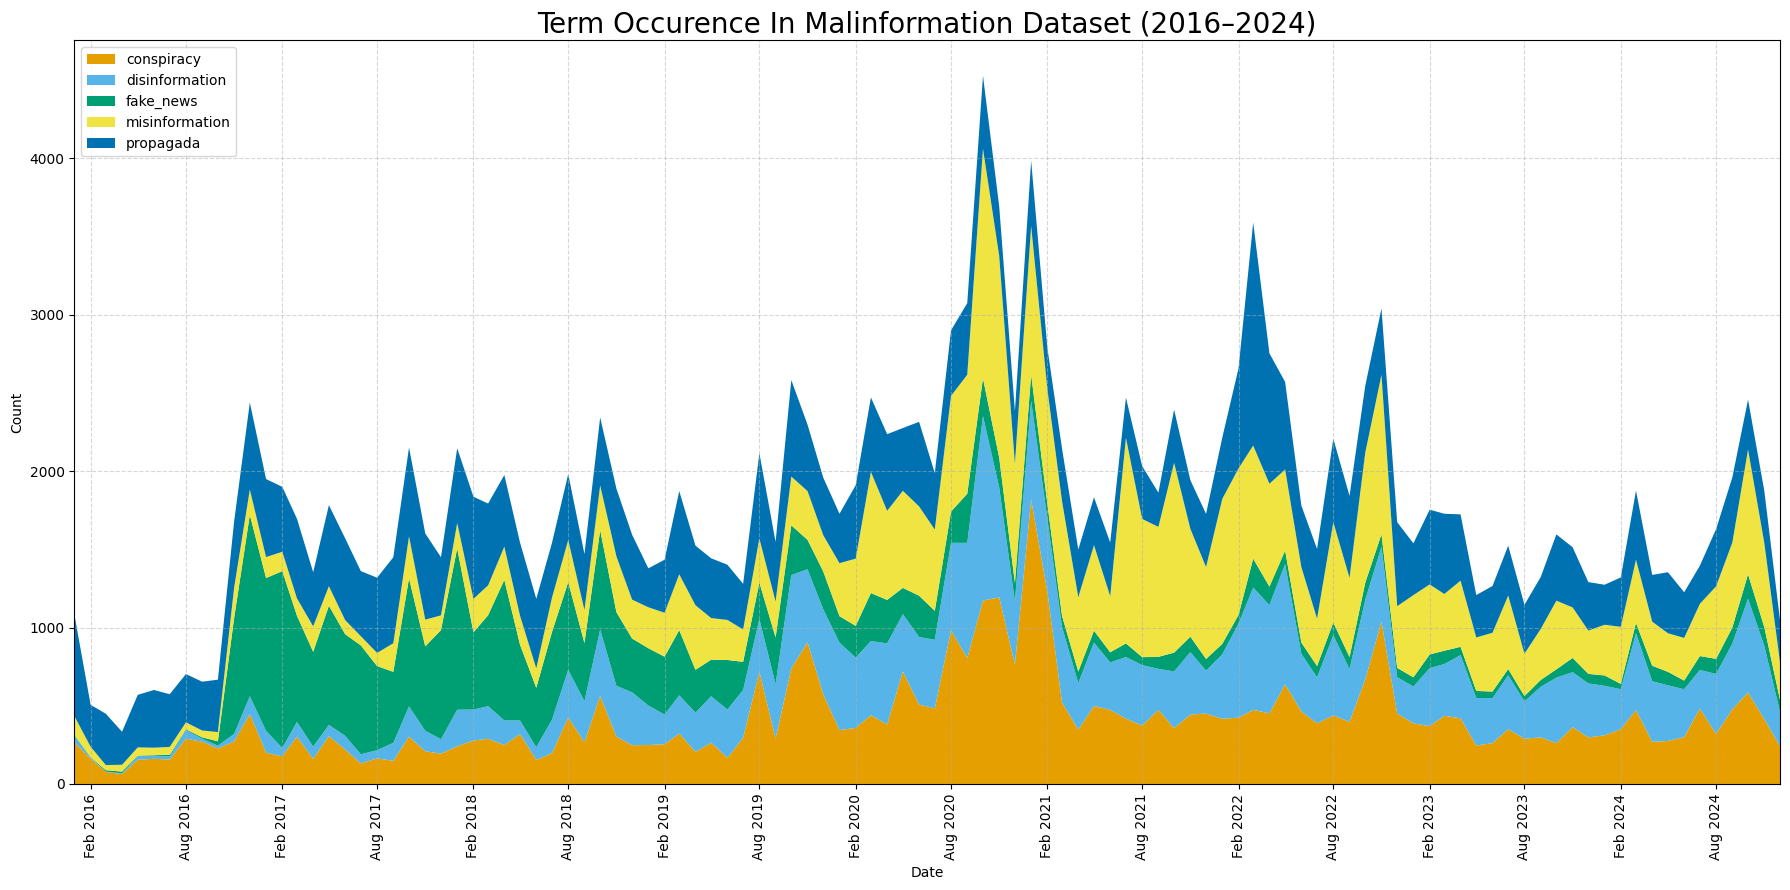

Saved plot as PNG: Term Occurence In Malinformation Dataset (1980–2024).png


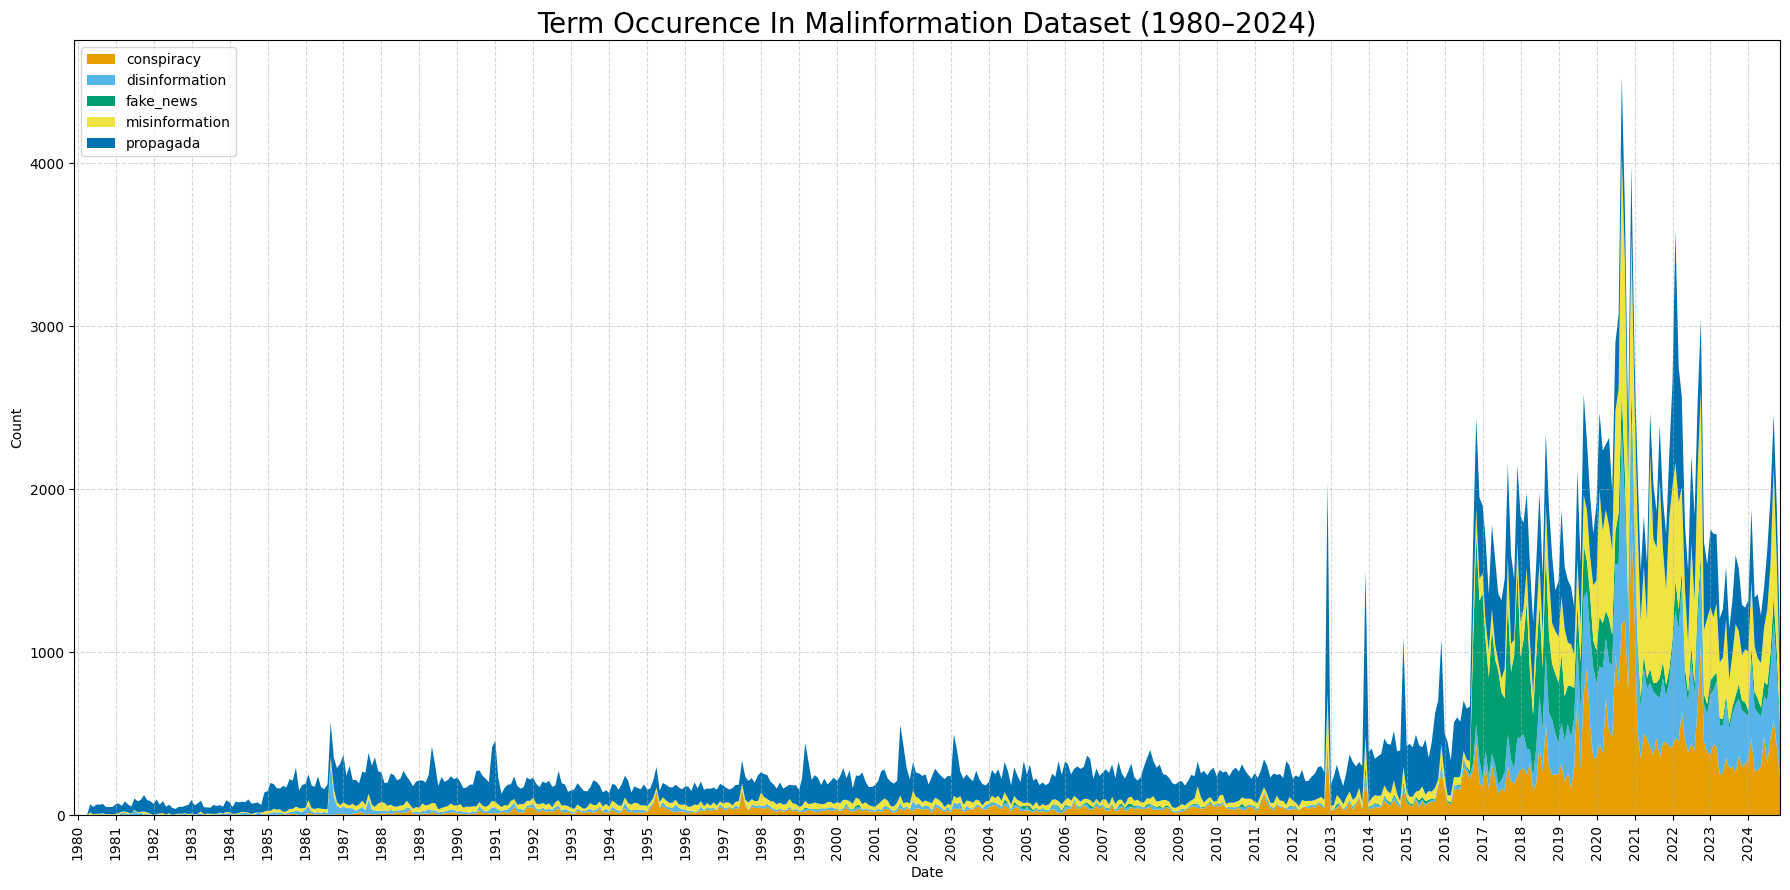

Saved plot as PNG: Platform Mentions In Malinformation Dataset (2016–2024).png


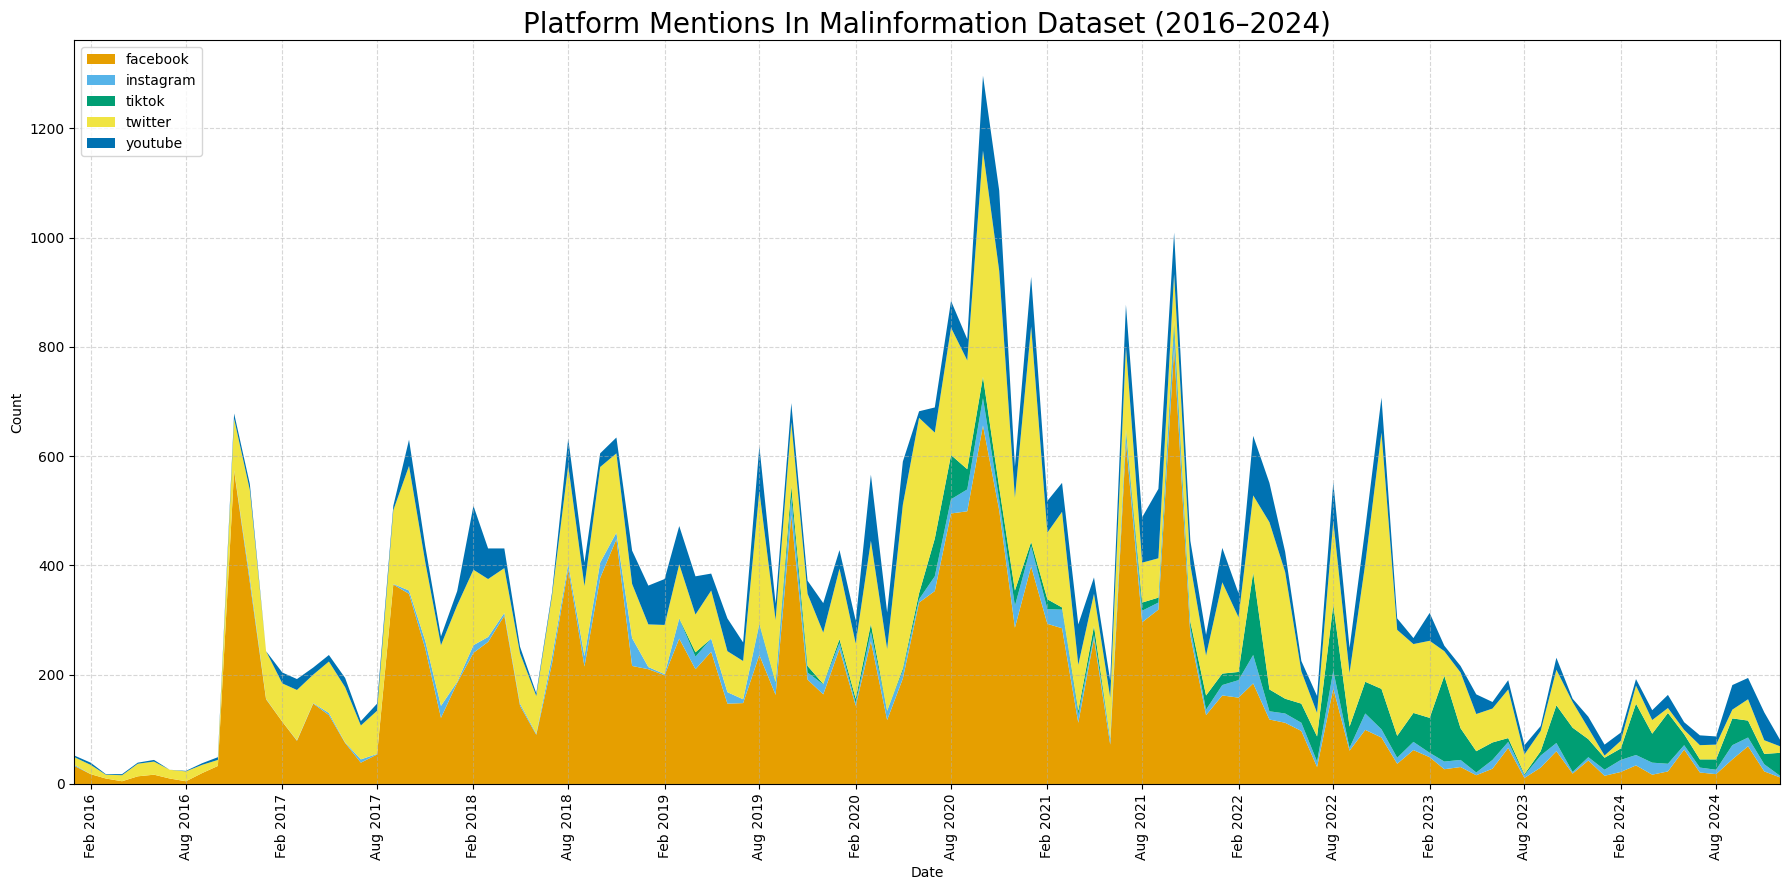

Saved plot as PNG: Platform Mentions In Malinformation Dataset (1980–2024).png


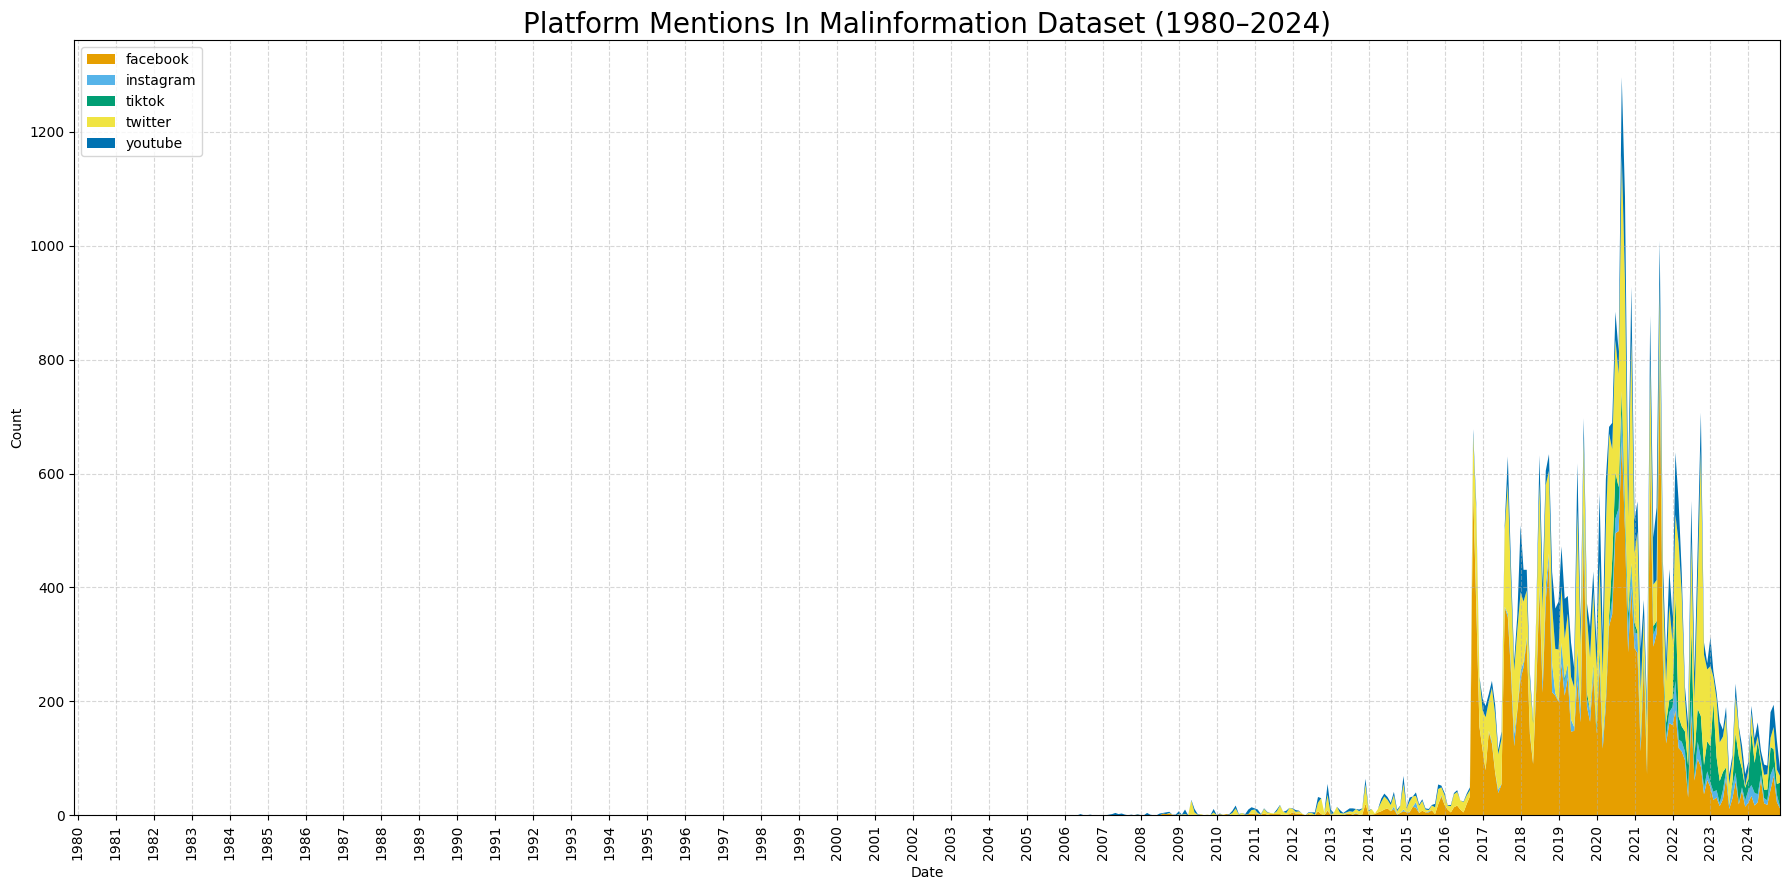

Saved plot as PNG: World Leader Mentions In Malinformation Dataset (2016–2024).png


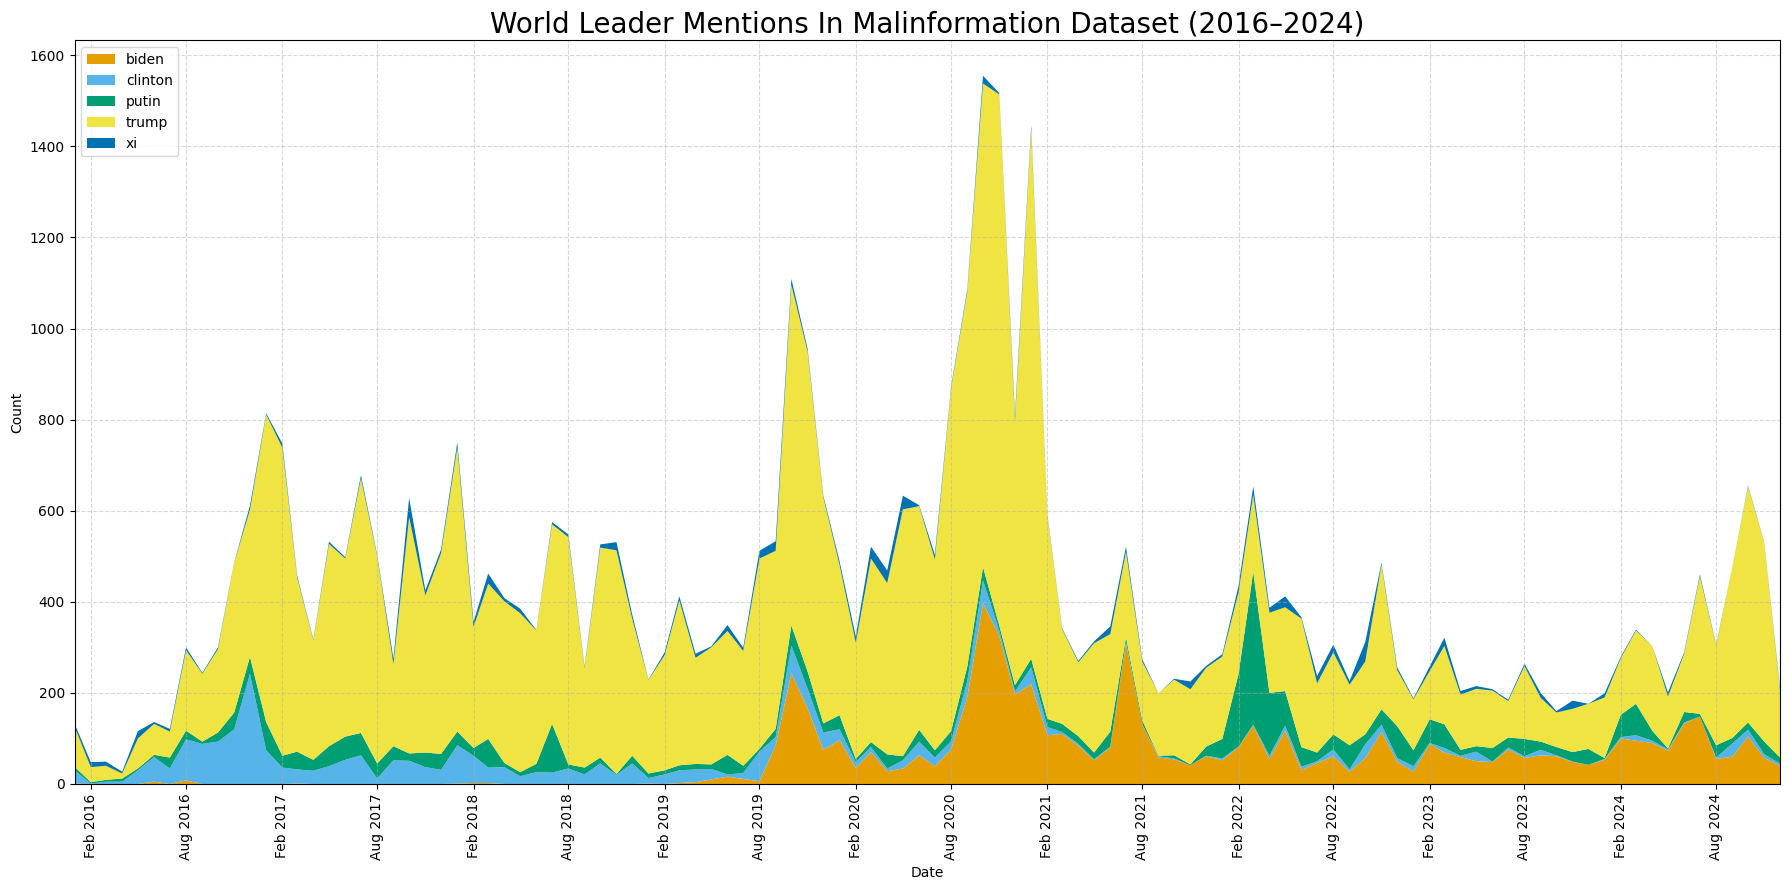

Saved plot as PNG: World Leader Mentions In Malinformation Dataset (1980–2024).png


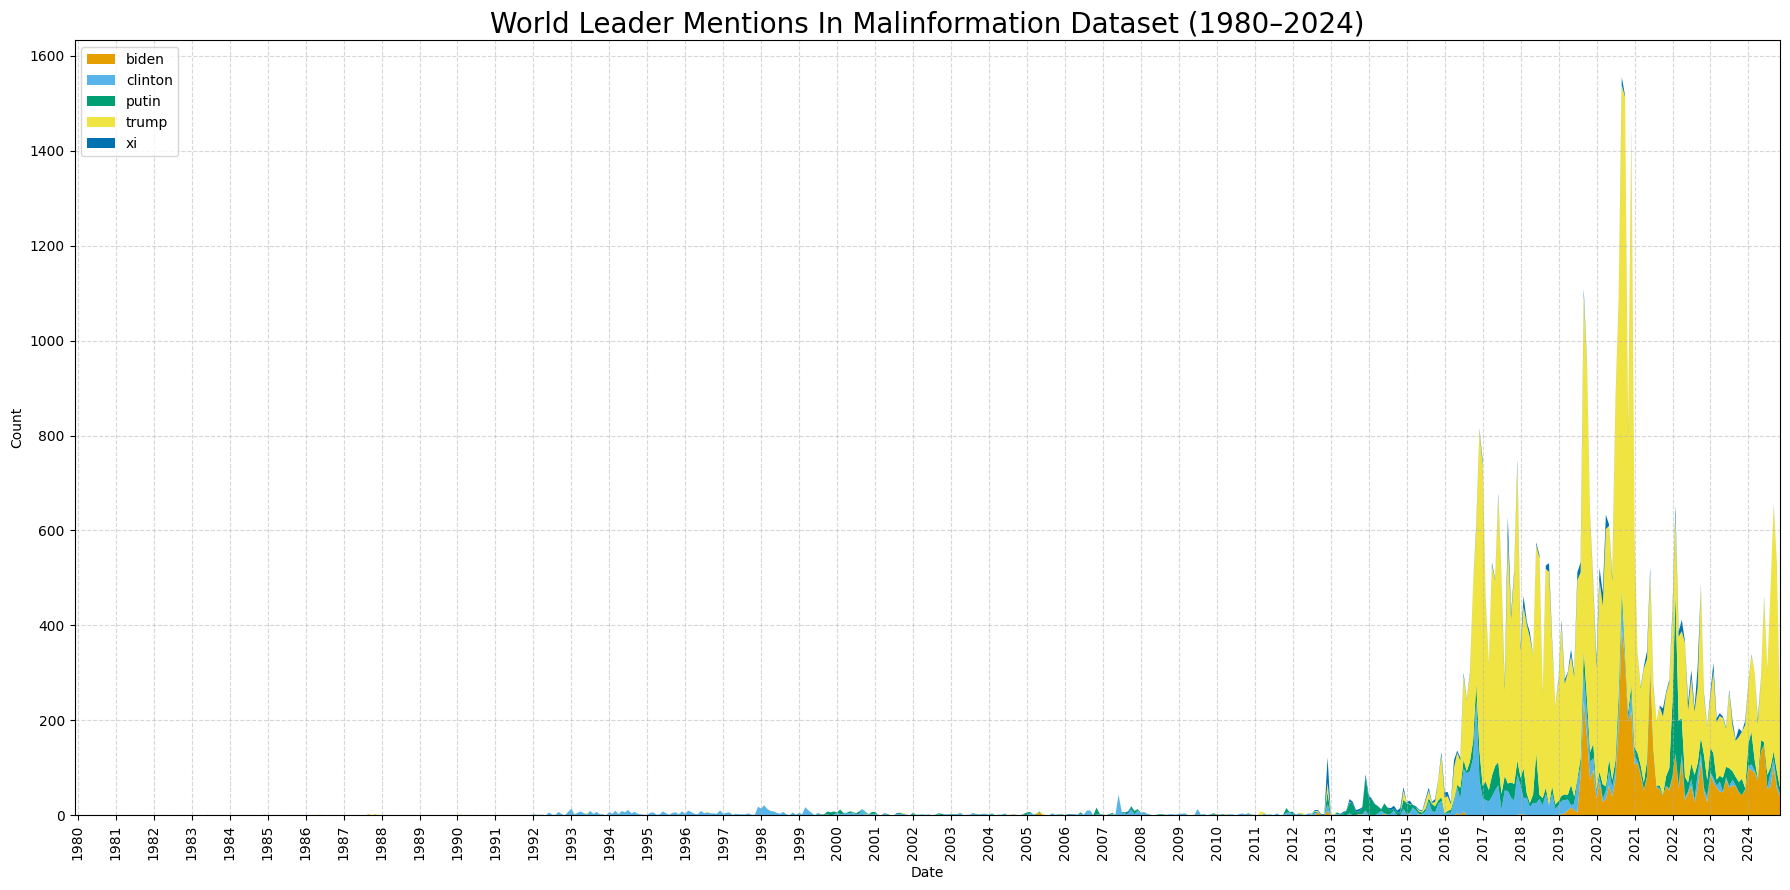

Saved plot as PNG: Non-US Country Mentions In Malinformation Dataset (2016–2024).png


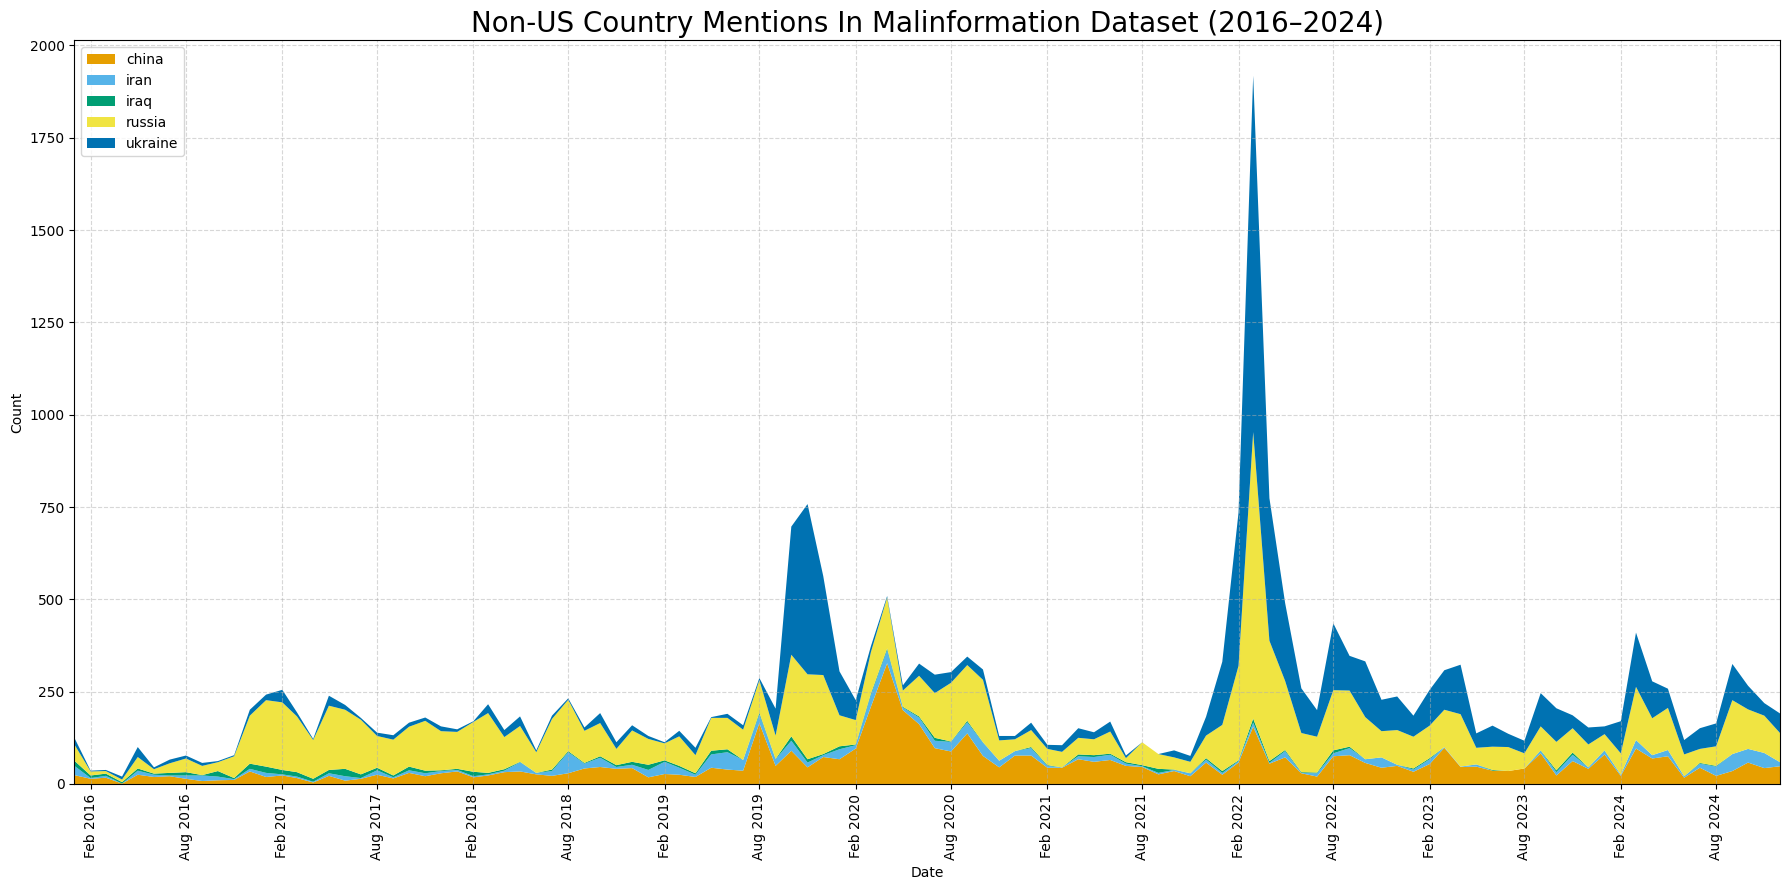

Saved plot as PNG: Non-US Country Mentions In Malinformation Dataset (1980–2024).png


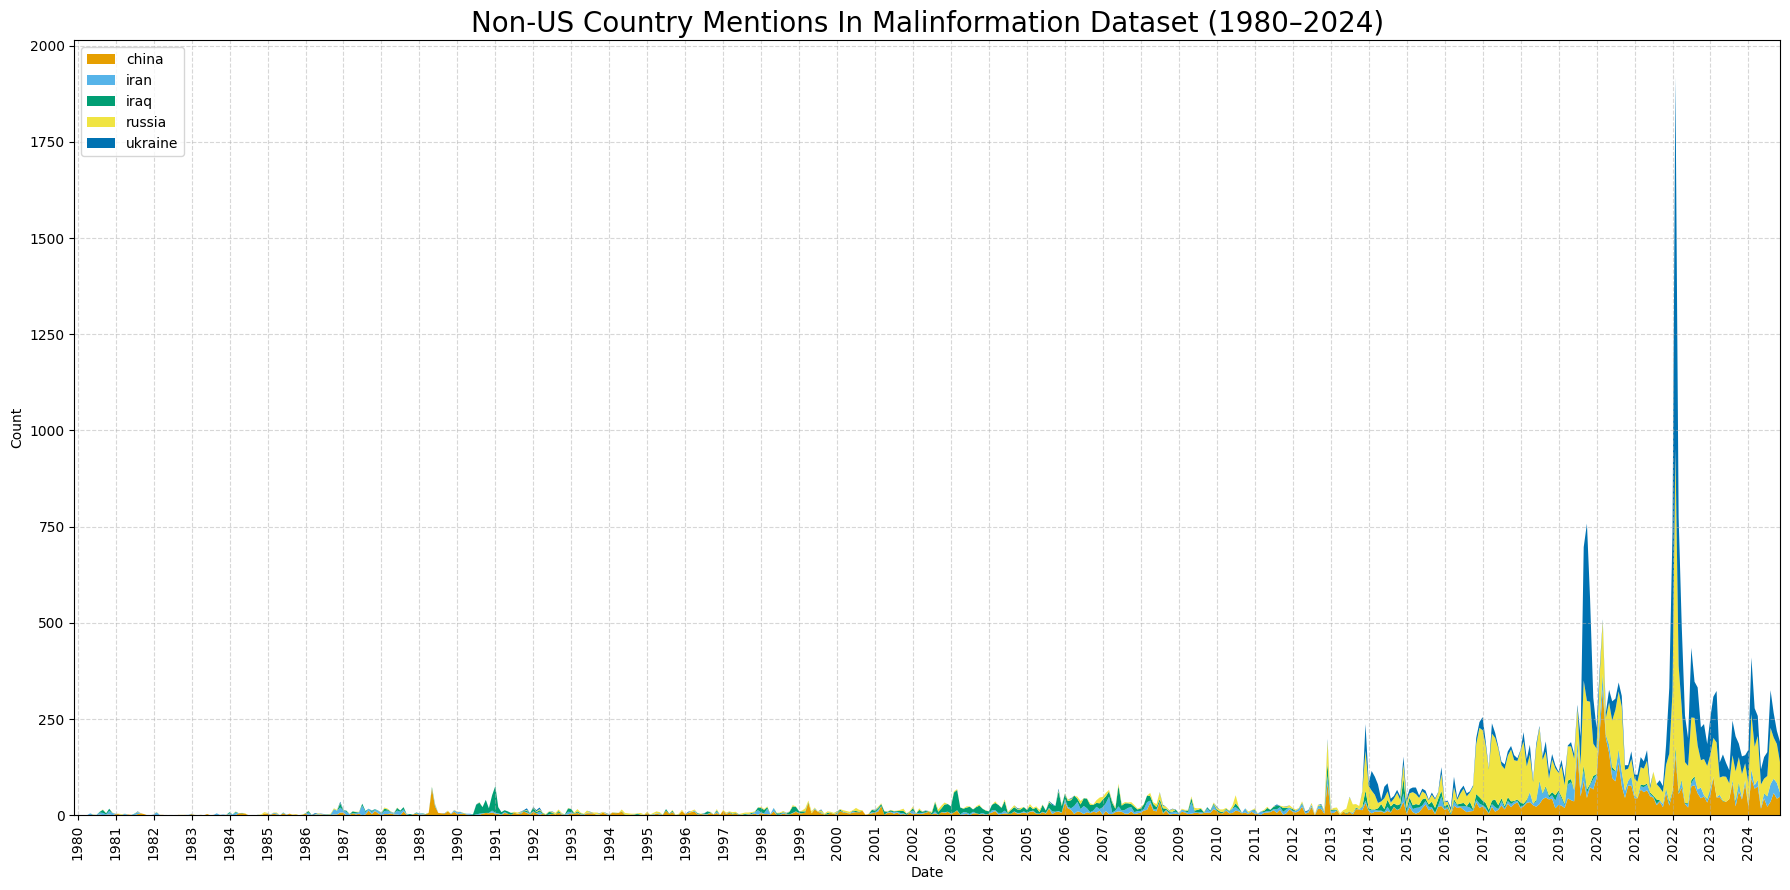

In [34]:

for object in searchObjectList:
    plot_stacked_area( f'FinalCombinedOutput/{object['title']}.csv', object['graph_title'], 2016, 2024)
    plot_stacked_area( f'FinalCombinedOutput/{object['title']}.csv', object['graph_title'], 1980, 2024)
 

# PACKAGE AND EXPORT DATA


In [ ]:
def zip_selected_items(include_list, output_zip='archive.zip'):
    current_dir = os.getcwd()

    with zipfile.ZipFile(output_zip, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for item in include_list:
            full_path = os.path.join(current_dir, item)

            if not os.path.exists(full_path):
                print(f"Skipping: {item} (not found)")
                continue

            if os.path.isfile(full_path):
                # Single file
                zipf.write(full_path, arcname=item)
            elif os.path.isdir(full_path):
                # Walk through directory
                for root, _, files in os.walk(full_path):
                    for file in files:
                        file_path = os.path.join(root, file)
                        arcname = os.path.relpath(file_path, current_dir)
                        zipf.write(file_path, arcname)

    print(f"Created zip archive: {output_zip}")


output_zipfile='MisinfoBeatData.zip'
include_these = ['MatrixResults', 'FinalCombinedOutput', 'Figures', 'MisinformationBeat1.ipynb', 'MisinformationBeat2.ipynb']
zip_selected_items(include_these, output_zip=output_zipfile)
data_to_export = output_zipfile





Created zip archive: MisinfoBeatData.zip
Created zip archive: MisinfoBeatRawData.zip


In [36]:
!aws s3 cp $data_to_export s3://pq-tdm-studio-results/tdm-ale-data/a2919/results/

'aws' is not recognized as an internal or external command,
operable program or batch file.
